Data shape: (567718, 20)

First 5 rows:
      FSC-A     FSC-H     SSC-A    FITC-A      PE-A  PE-CF594-A  \
0  0.519561  0.460912  0.509205  0.027461  0.057584    0.069241   
1  0.466627  0.372021  0.563659  0.027979  0.058033    0.068948   
2  0.695993  0.633093  0.457409  0.027322  0.057545    0.069003   
3  0.470678  0.437775  0.645361  0.030165  0.060082    0.070658   
4  0.552609  0.491154  0.427686  0.027681  0.057129    0.068643   

   PerCP-Cy5-5-A     PC7-A     APC-A  APC-Alexa 700-A  APC AF750-A   BV421-A  \
0       0.096542  0.049735  0.017811         0.025838     0.026584  0.037767   
1       0.096456  0.048851  0.018698         0.025172     0.026661  0.037952   
2       0.096224  0.050463  0.018011         0.024686     0.023180  0.037816   
3       0.095815  0.050661  0.018927         0.026468     0.025948  0.040198   
4       0.097178  0.048200  0.018479         0.025204     0.024806  0.038245   

    BV510-A   BV605-A   BV650-A   BV711-A   BV786-A  BUV395-A  BUV737-A  Tim


NMF Results:
- W shape (Cells × Components): (567718, 3)
- H shape (Components × Markers): (3, 20)

Top 5 cells in W matrix:
   Component_1  Component_2  Component_3
0     0.211983     0.271357     0.011507
1     0.270744     0.220388     0.009290
2     0.125046     0.388104     0.012616
3     0.303992     0.237487     0.007301
4     0.153047     0.298366     0.014429

Marker contributions (H matrix):
                 Component_1  Component_2  Component_3
FSC-A               0.432068     1.716145     0.000000
FSC-H               0.000000     1.587172     0.026054
SSC-A               1.550402     0.756544     0.010593
FITC-A              0.047323     0.032644     0.023568
PE-A                0.096408     0.063482     0.050110
PE-CF594-A          0.117079     0.074097     0.060686
PerCP-Cy5-5-A       0.166452     0.117044     0.079923
PC7-A               0.080085     0.064257     0.042576
APC-A               0.040228     0.029615     0.013102
APC-Alexa 700-A     0.049942     0.036141   

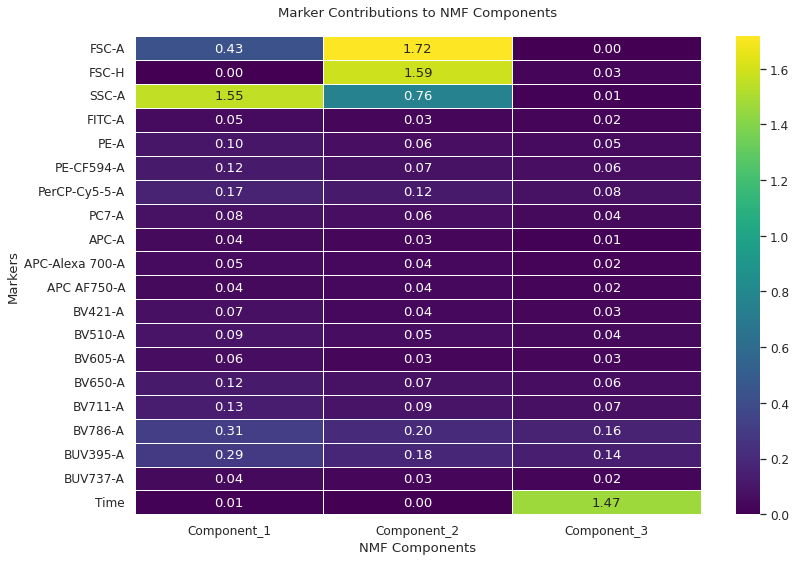

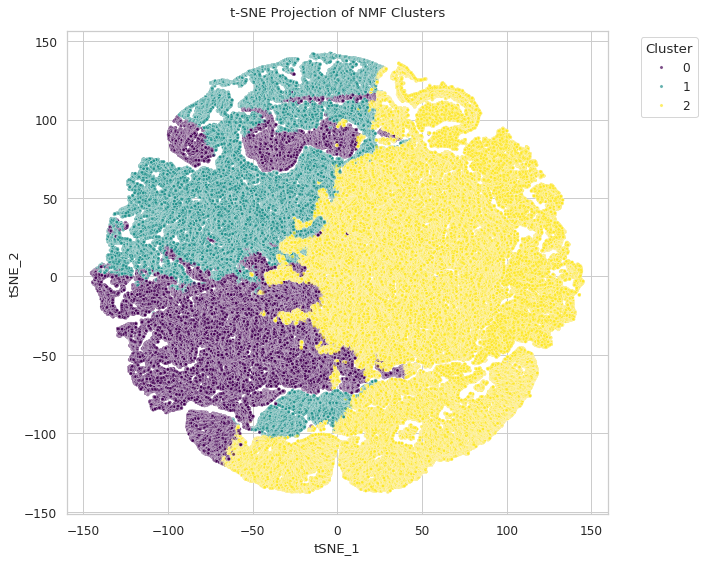


Most important markers per component:
                 Component_1  Component_2  Component_3 Dominant_Component
APC-Alexa 700-A     0.049942     0.036141     0.019778        Component_1
BV650-A             0.119357     0.074237     0.059106        Component_1
BV605-A             0.057039     0.033055     0.027018        Component_1
BV510-A             0.090359     0.054405     0.043074        Component_1
BV421-A             0.068225     0.039616     0.033131        Component_1
APC AF750-A         0.041849     0.038521     0.022339        Component_1
BUV737-A            0.044088     0.032999     0.023009        Component_1
BV711-A             0.132647     0.089702     0.068543        Component_1
APC-A               0.040228     0.029615     0.013102        Component_1
PerCP-Cy5-5-A       0.166452     0.117044     0.079923        Component_1
PE-CF594-A          0.117079     0.074097     0.060686        Component_1
PE-A                0.096408     0.063482     0.050110        Component_1

In [ ]:
# =============================================
# 1. SETUP & CONFIGURATION
# =============================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE
import FlowCal

# Set global styles for plots
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (10, 6)

# =============================================
# 2. DATA LOADING & PREPROCESSING
# =============================================
def load_and_normalize_fcs(fcs_path):
    """Load FCS file and normalize data."""
    fcs_data = FlowCal.io.FCSData(fcs_path)
    df = pd.DataFrame(fcs_data, columns=fcs_data.channels)
    df = (df - df.min()) / (df.max() - df.min())  # Min-Max scaling
    return df

# Load data
fcs_path = "Enter_your_input_fcs_file_path"
df = load_and_normalize_fcs(fcs_path)

print(f"Data shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

# =============================================
# 3. DIMENSIONALITY REDUCTION (PCA)
# =============================================
def find_optimal_components(df, variance_threshold=0.95):
    """Use PCA to determine the optimal number of NMF components."""
    pca = PCA()
    pca.fit(df)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    optimal_n = np.argmax(explained_variance >= variance_threshold) + 1
    return optimal_n

optimal_n = find_optimal_components(df)
print(f"\nOptimal NMF components (explains 95% variance): {optimal_n}")

# =============================================
# 4. NON-NEGATIVE MATRIX FACTORIZATION (NMF)
# =============================================
def run_nmf(df, n_components, max_iter=500, random_state=42):
    """Run NMF and return W (cell clusters) and H (marker contributions)."""
    nmf = NMF(n_components=n_components, init='random', max_iter=max_iter, random_state=random_state)
    W = nmf.fit_transform(df)  # Cell embeddings (n_cells × n_components)
    H = nmf.components_        # Marker weights (n_components × n_markers)
    return W, H

W, H = run_nmf(df, optimal_n)

print("\nNMF Results:")
print(f"- W shape (Cells × Components): {W.shape}")
print(f"- H shape (Components × Markers): {H.shape}")

# Convert to DataFrames
W_df = pd.DataFrame(W, columns=[f"Component_{i+1}" for i in range(W.shape[1])])
H_df = pd.DataFrame(H.T, index=df.columns, columns=[f"Component_{i+1}" for i in range(H.shape[0])])

print("\nTop 5 cells in W matrix:")
print(W_df.head())

print("\nMarker contributions (H matrix):")
print(H_df)

# =============================================
# 5. VISUALIZATION
# =============================================
def plot_heatmap(H_df):
    """Plot heatmap of marker contributions."""
    plt.figure(figsize=(12, 8))
    sns.heatmap(H_df, cmap="viridis", annot=True, fmt=".2f", linewidths=0.5)
    plt.title("Marker Contributions to NMF Components", pad=20)
    plt.xlabel("NMF Components")
    plt.ylabel("Markers")
    plt.tight_layout()
    plt.show()

def plot_tsne(W, n_clusters=3):
    """Visualize NMF clusters using t-SNE."""
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(W)
    
    df_tsne = pd.DataFrame(tsne_result, columns=["tSNE_1", "tSNE_2"])
    df_tsne["Cluster"] = np.argmax(W, axis=1)  # Assign cluster based on dominant NMF component
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=df_tsne,
        x="tSNE_1",
        y="tSNE_2",
        hue="Cluster",
        palette="viridis",
        alpha=0.7,
        s=10,
    )
    plt.title("t-SNE Projection of NMF Clusters", pad=15)
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_heatmap(H_df)
plot_tsne(W)

# =============================================
# 6. INTERPRETATION & SAVING RESULTS
# =============================================
def get_dominant_markers(H_df):
    """Identify the most important markers per component."""
    dominant_markers = H_df.copy()
    dominant_markers["Dominant_Component"] = dominant_markers.idxmax(axis=1)
    return dominant_markers.sort_values(by="Dominant_Component")

dominant_markers = get_dominant_markers(H_df)
print("\nMost important markers per component:")
print(dominant_markers)

# Save results (optional)
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)
W_df.to_csv(("NMF_cell_components.csv"), index=False)
H_df.to_csv(("NMF_marker_contributions.csv"), index=True)
print(f"\nResults saved to the specified directory.")